In [1]:
import lbg_forecast.priors as pr
import numpy as np
import matplotlib.pyplot as plt
import emcee
from getdist import plots, MCSamples

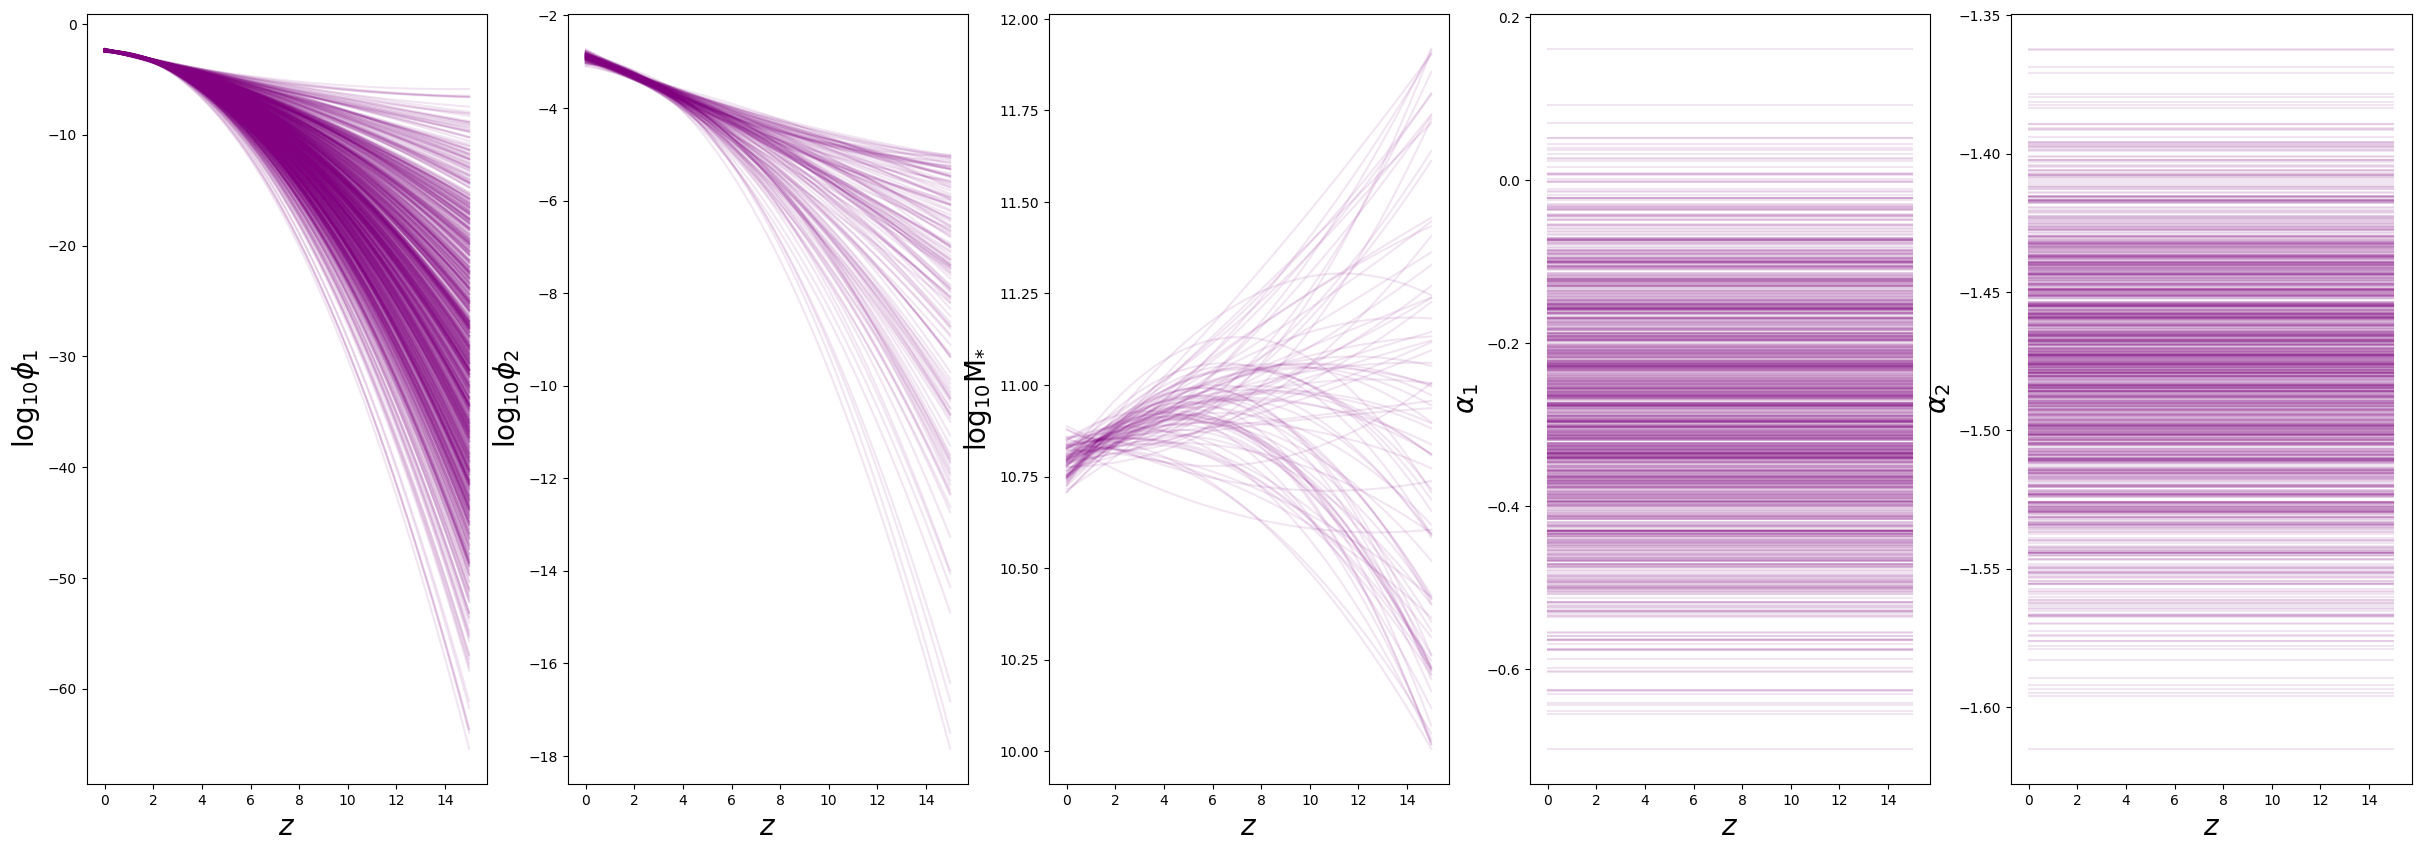

In [2]:
z_grid = np.linspace(0.0, 15.0, 50)
nsamples=1000
curves = pr.mass_function_parameter_curves(z_grid, nsamples, truth=False)
selected_curves = pr.select_allowed_parameter_curves(z_grid, curves)
pr.plot_mass_function_parameter_curves(z_grid, selected_curves, alpha=0.1)


(1000, 50) (1000, 50) (1000, 50) (1000, 50) (1000, 50)


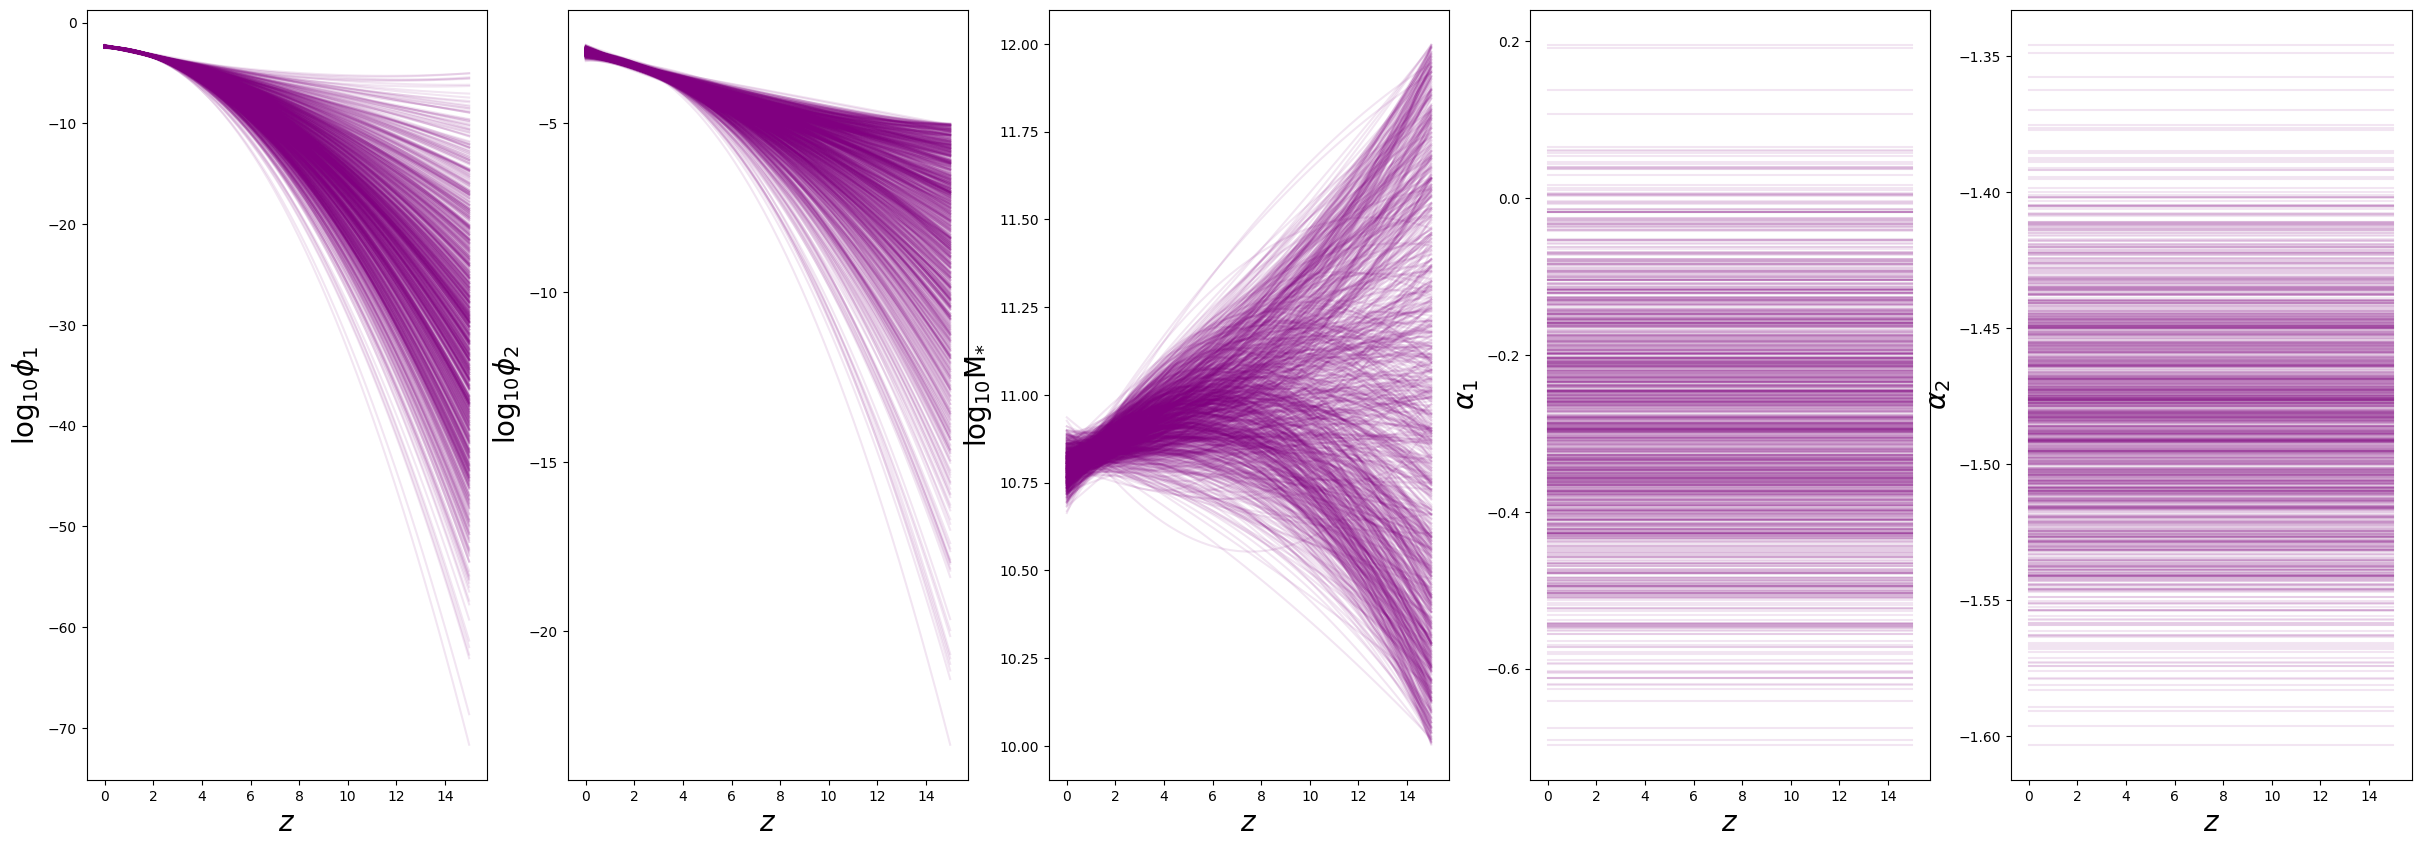

In [3]:
z_grid = np.linspace(0.0, 15.0, 50)
nsamples=1000000
curves = pr.mass_function_parameter_curves(z_grid, nsamples, truth=False)
allowed_curves = pr.select_allowed_parameter_curves(z_grid, curves)

sampled_curves = pr.sample_allowed_parameter_curves(z_grid, 1000, allowed_curves)
print(sampled_curves[0].shape, sampled_curves[1].shape, sampled_curves[2].shape, sampled_curves[3].shape, sampled_curves[4].shape)
pr.plot_mass_function_parameter_curves(z_grid, sampled_curves, alpha=0.1)

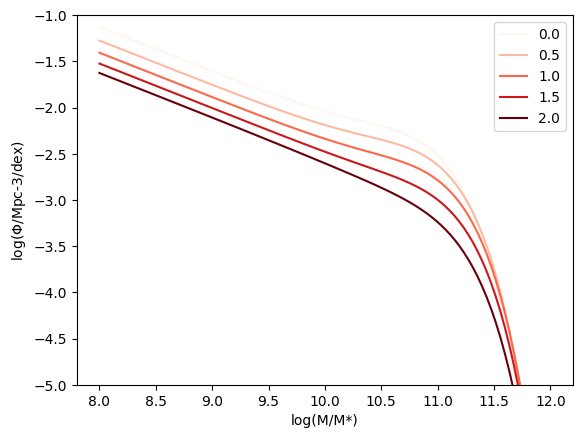

In [4]:
pr.plot_observed_mass_function()

(0.0, 3.0)

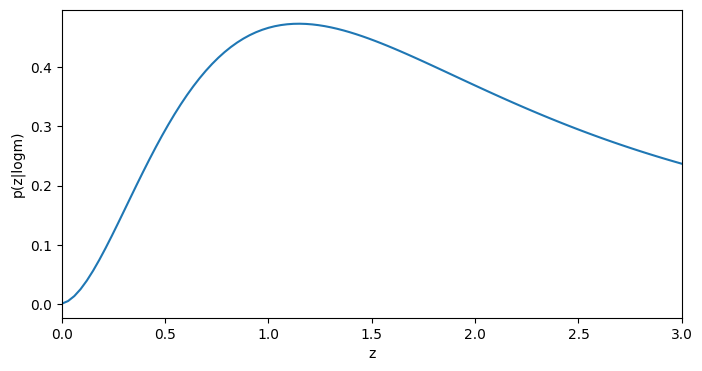

In [5]:
plt.figure(figsize=(8,4))
pr.plot_observed_nz()
plt.xlim(0, 3)

In [6]:
from astropy.cosmology import WMAP9
import numpy as np
import matplotlib.pyplot as plt

def preload_parameter_curves(nprior_draws, z_grid, init_nsamples, truth=False):
    """preloads a set of logphi1, logphi2, logm*, alpha1, alpha2 curves
    as function of redshift
    """
    if(truth):
        preloaded_curves = pr.mass_function_parameter_curves(z_grid, 1, truth=truth)
    else:
        curves = pr.mass_function_parameter_curves(z_grid, init_nsamples, truth=truth)
        allowed_curves = pr.select_allowed_parameter_curves(z_grid, curves)
        preloaded_curves = pr.sample_allowed_parameter_curves(z_grid, nprior_draws, allowed_curves)

    return preloaded_curves

def draw_parameter_curves(preloaded_curves):
    """samples a single set of curves from preloaded 
    set of logphi1, logphi2, logm*, alpha1, alpha2 curves taken
    from preload_parameter_curves()
    
    """
    nsampled_curves = preloaded_curves[0].shape[0]
    curve_index = np.random.randint(0, nsampled_curves)
    sampled_curves = []
    for param in preloaded_curves:
        sampled_curves.append(param[curve_index, :])
    
    sampled_curves = np.vstack(sampled_curves)

    return sampled_curves

def plot_parameter_curves(z_grid, sampled_curves, **kwargs):
    """Plots output of draw_parameter_curves() only
    
    """
    fig, axes = plt.subplots(1, 5)
    fig.set_figheight(10)
    fig.set_figwidth(30)
    ylabels = ['log$_{10}\phi_{1}$', 'log$_{10}\phi_{2}$', 'log$_{10}\mathrm{M}_{*}$',r'$\alpha_{1}$', r'$\alpha_{2}$']

    indx = 0
    while(indx < 5):
        axes[indx].plot(z_grid, sampled_curves[indx, :], c='purple', **kwargs)
        axes[indx].set_xlabel('$z$', fontsize=20)
        axes[indx].set_ylabel(ylabels[indx], fontsize=20)
        indx+=1

def schechter_function(logm, logphi, logm_star, alpha):
    
    return np.log(10)*(10**logphi)*10**((logm-logm_star)*(alpha+1))*np.exp(-10**(logm-logm_star))

def mass_function(z, logm, z_dependence, z_grid):

    z_dependent_parameters = []
    indx = 0
    while(indx < 5):
        z_dependent_parameters.append(np.interp(z, z_grid, z_dependence[indx, :]))
        indx+=1

    logphi1, logphi2, logm_star, alpha1, alpha2 = z_dependent_parameters
    mfunc = schechter_function(logm, logphi1, logm_star, alpha1) + schechter_function(logm, logphi2, logm_star, alpha2)

    if(mfunc < 1e-100):
        mfunc = 1e-100

    return mfunc

def log_n(x, z_dependence, z_grid, v_grid, prior_bounds=[0.0,3.0,9.99,10.01]):

    z, logm = x

    if(z < prior_bounds[0] or z > prior_bounds[1]):
        return -np.inf
    
    if(logm < prior_bounds[2] or logm > prior_bounds[3]):
        return -np.inf
    
    phi = mass_function(z, logm, z_dependence, z_grid)
    volumes = np.interp(z, z_grid, v_grid)
    ngalaxies = phi*volumes

    return np.log(ngalaxies)

def reproduce_plots(nwalkers=50, steps=5000):
    """takes approx 2mins
    """
    #setup
    z_grid = np.linspace(0.0, 3.0, 50)
    v_grid = pr.volume_elements(z_grid)
    preloaded_z_dependent_curves = preload_parameter_curves(1000, z_grid, 1000000, truth=True)
    sampled_curves = draw_parameter_curves(preloaded_z_dependent_curves)
    plot_parameter_curves(z_grid, sampled_curves)

    #sampling
    ndim = 2
    pz = np.random.uniform(1.01, 1.02, (nwalkers, 1))
    plogm = np.random.uniform(9.9999, 10.0001, (nwalkers, 1))
    p0 = np.hstack((pz, plogm))
    prior_bounds=[0.0,3.0,9.99,10.01]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_n, args=[sampled_curves, z_grid, v_grid, prior_bounds])

    state = sampler.run_mcmc(p0, 100)
    sampler.reset()

    sampler.run_mcmc(state, steps)

    #plotting

    samples = sampler.get_chain(flat=True)
    s = MCSamples(samples=samples, names=["z", "logm"])
    plotter = plots.get_subplot_plotter()
    plotter.triangle_plot([s], Filled=True, contour_lws=2)
    print(samples.shape)

    figure, axes = plt.subplots(1,1)
    axes.hist(samples[:, 0], bins=50, density=True)
    pr.plot_observed_nz()

def sample(nwalkers=50, steps=5000):
    """
    """
    #setup
    z_grid = np.linspace(0.0, 15.0, 50)
    v_grid = pr.volume_elements(z_grid)
    preloaded_z_dependent_curves = preload_parameter_curves(1000, z_grid, 1000000, truth=False)
    sampled_curves = draw_parameter_curves(preloaded_z_dependent_curves)
    plot_parameter_curves(z_grid, sampled_curves)

    #sampling
    ndim = 2
    pz = np.random.uniform(1.01, 1.02, (nwalkers, 1))
    plogm = np.random.uniform(9.9, 10.1, (nwalkers, 1))
    p0 = np.hstack((pz, plogm))
    prior_bounds=[0.0,10.0,7,13]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_n, args=[sampled_curves, z_grid, v_grid, prior_bounds])

    state = sampler.run_mcmc(p0, 100)
    sampler.reset()

    sampler.run_mcmc(state, steps)

    #plotting

    samples = sampler.get_chain(flat=True)
    s = MCSamples(samples=samples, names=["z", "logm"])
    plotter = plots.get_subplot_plotter()
    plotter.triangle_plot([s], Filled=True, contour_lws=2)
    print(samples.shape)

def sample_redshift_mass_prior(prior_data, nwalkers=50, steps=5000, prior_bounds=[0.0,10.0,7,13], plotting=False):
    """
    """
    #setup
    preloaded_z_dependent_curves, z_grid, v_grid = prior_data
    sampled_curves = draw_parameter_curves(preloaded_z_dependent_curves)

    #sampling
    ndim = 2
    pz = np.random.uniform(1.01, 1.02, (nwalkers, 1))
    plogm = np.random.uniform(9.9, 10.1, (nwalkers, 1))
    p0 = np.hstack((pz, plogm))

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_n, args=[sampled_curves, z_grid, v_grid, prior_bounds])

    state = sampler.run_mcmc(p0, 100)
    sampler.reset()

    sampler.run_mcmc(state, steps)

    #plotting
    samples = sampler.get_chain(flat=True)
    redshift_samples = samples[:, 0]
    mass_samples = samples[:, 1]
    if(plotting):
        plot_parameter_curves(z_grid, sampled_curves)
        plot_redshift_mass_prior(redshift_samples, mass_samples)

    return redshift_samples, mass_samples

def plot_redshift_mass_prior(redshift_samples, mass_samples):
        
        samples = np.hstack((np.reshape(redshift_samples, (len(redshift_samples), 1)), np.reshape(mass_samples,  (len(mass_samples), 1))))
        print(samples.shape)
        s = MCSamples(samples=samples, names=["z", "logm"])
        plotter = plots.get_subplot_plotter()
        plotter.triangle_plot([s], Filled=True, contour_lws=2)

        fig, ax = plt.subplots(1, 2)
        fig.set_figheight(10)
        fig.set_figwidth(30)
        ax[0].hist(redshift_samples, bins=50)
        ax[1].hist(mass_samples, bins=50)

def preload_prior_data(zmax=15.0):
    z_grid = np.linspace(0.0, zmax, 100)
    v_grid = pr.volume_elements(z_grid)
    preloaded_z_dependent_curves = preload_parameter_curves(1000, z_grid, 1000000, truth=False)

    return preloaded_z_dependent_curves, z_grid, v_grid

In [7]:
prior_data = preload_prior_data(zmax=15.0)

(50000, 2)
Removed no burn in


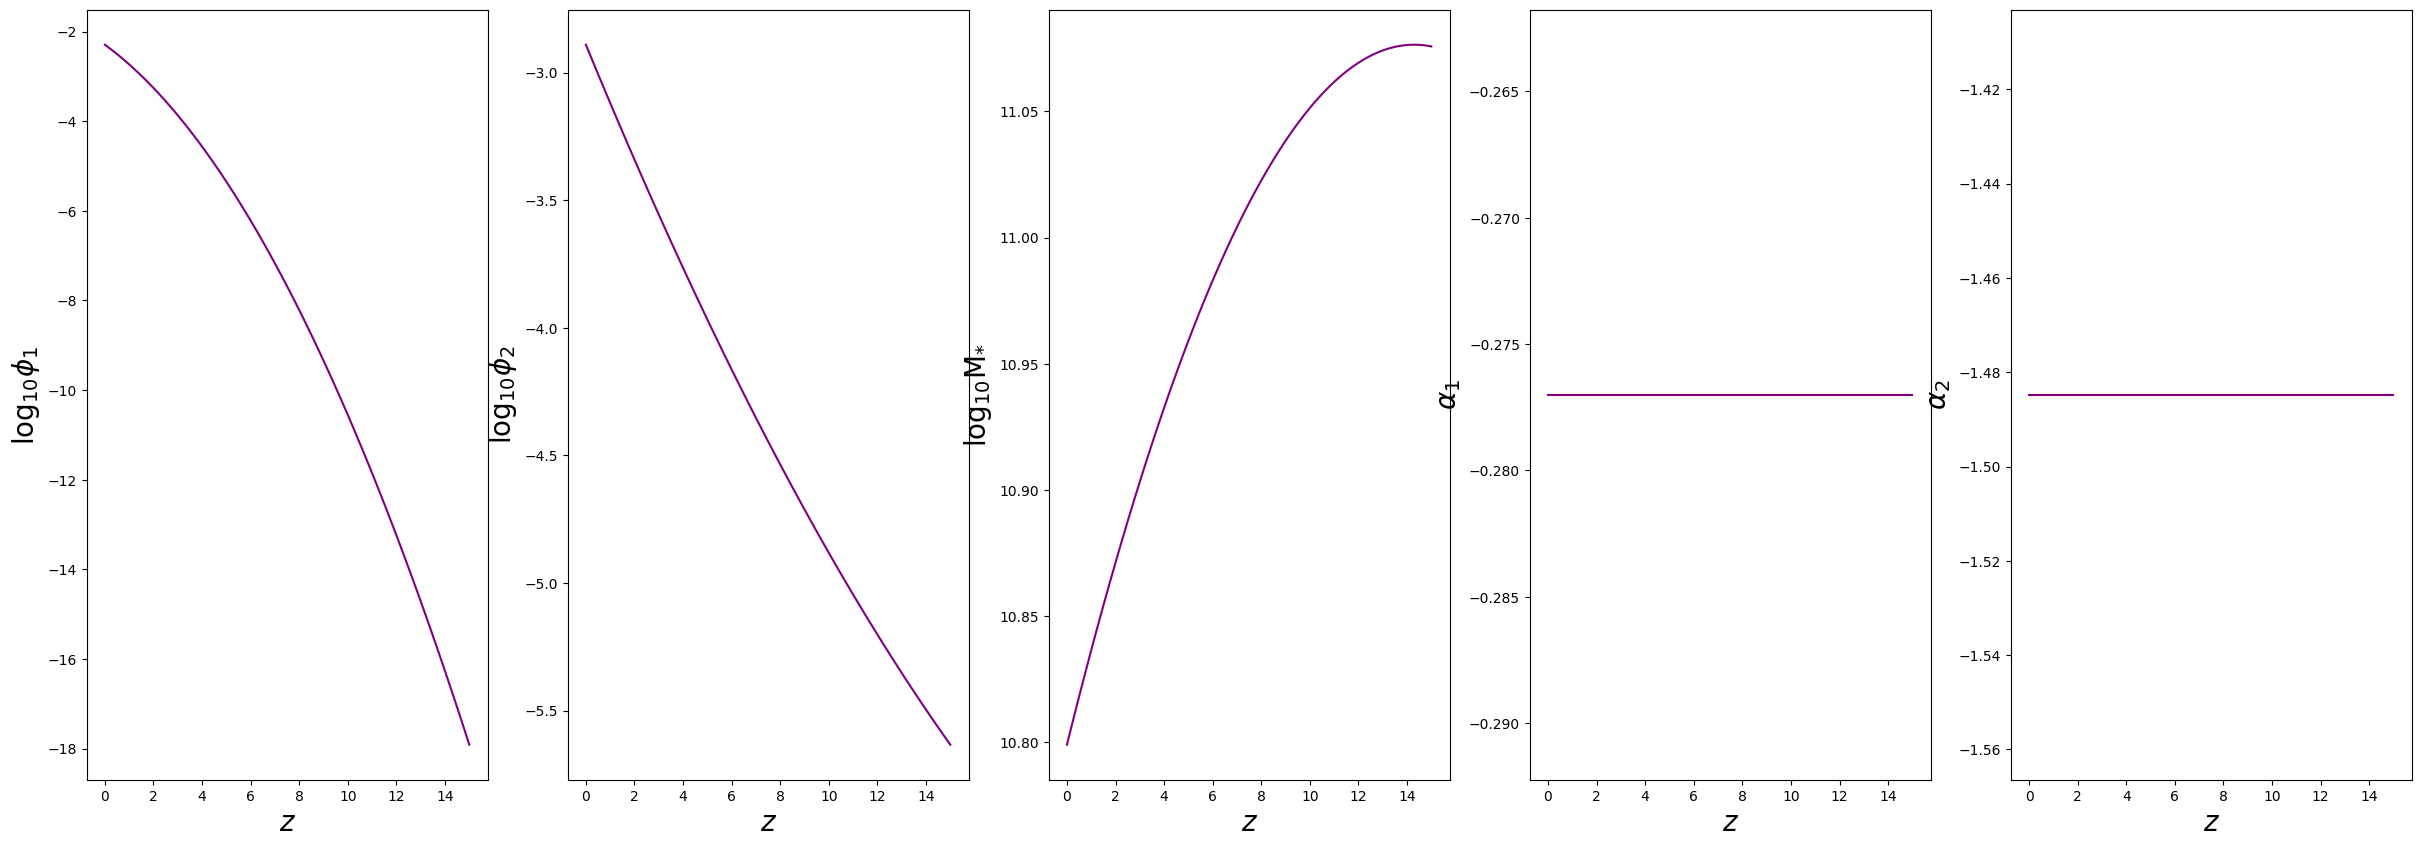

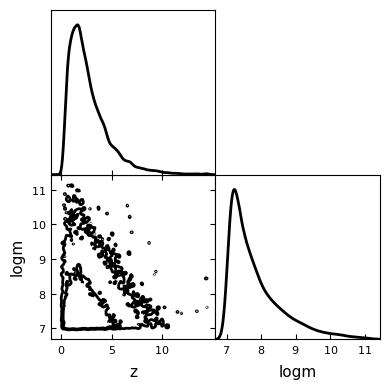

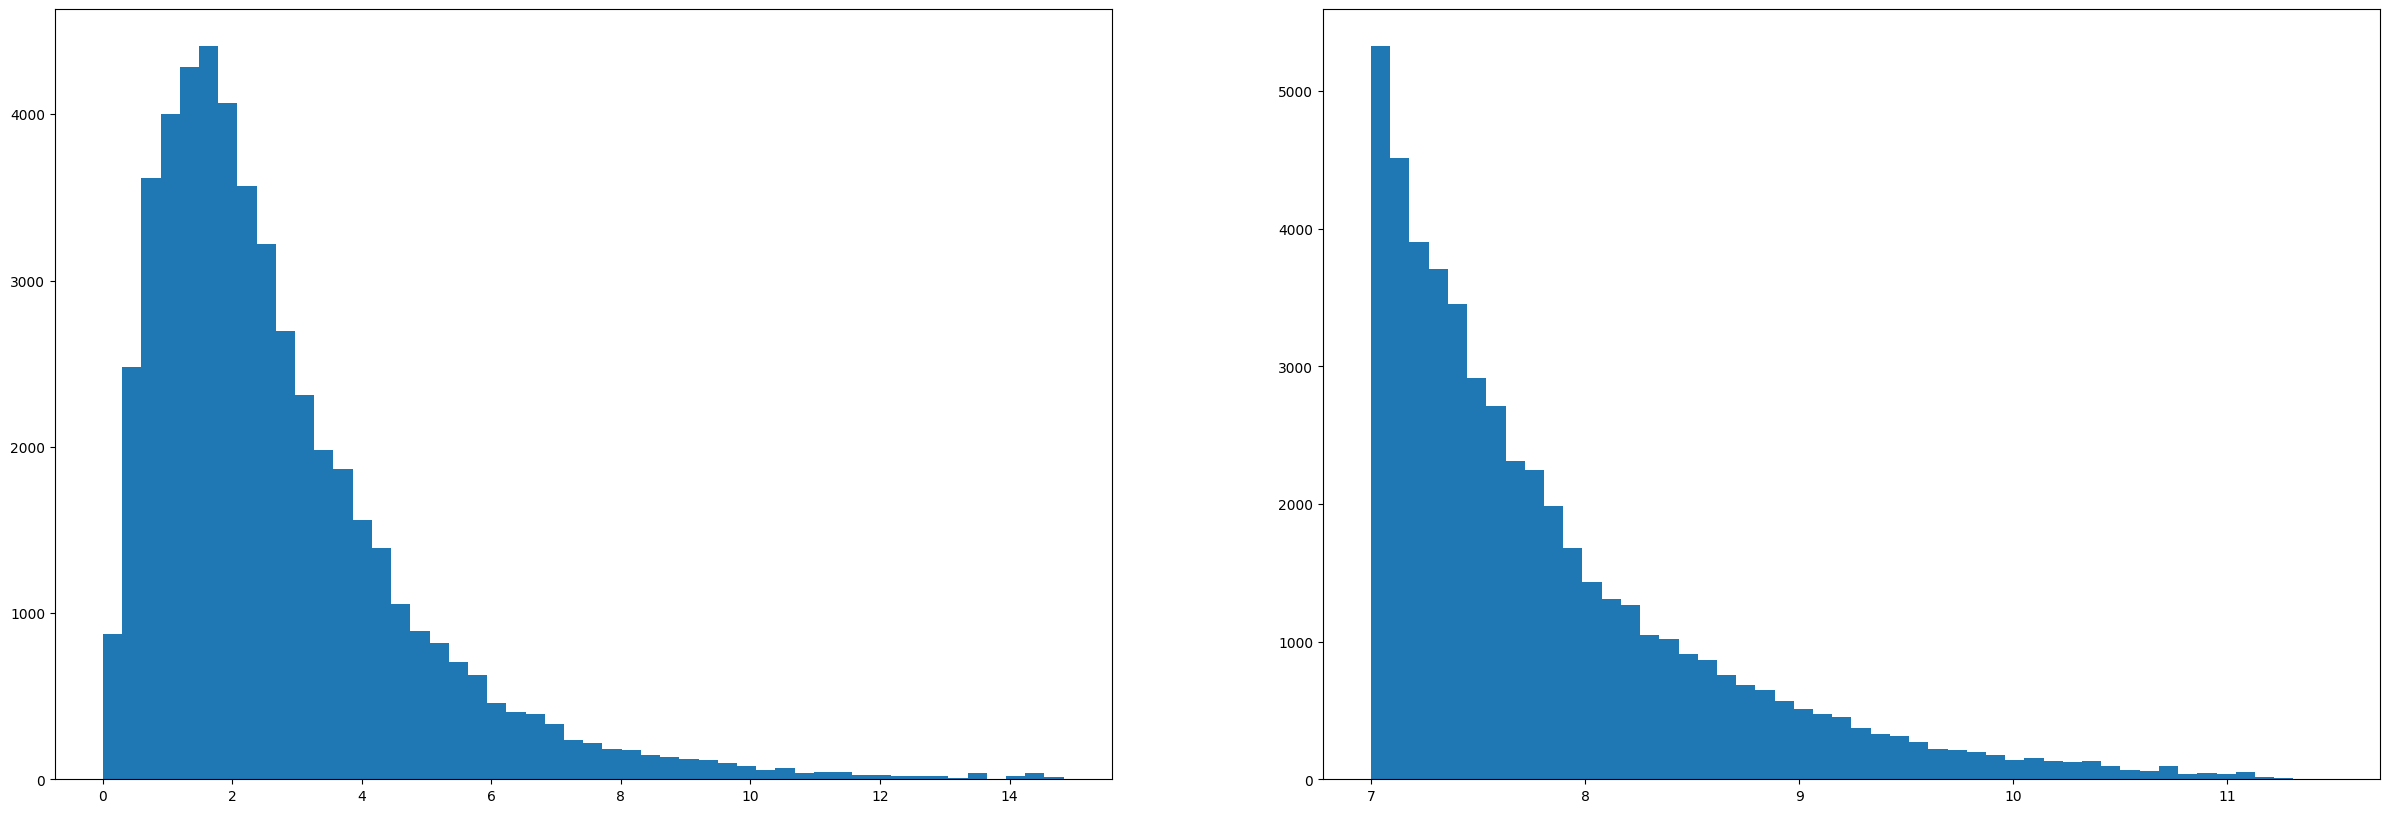

In [20]:
zsamples, logmsamples = sample_redshift_mass_prior(prior_data, 50, 1000, prior_bounds=[0.0,15.0,7,13], plotting=True)
#plot_redshift_mass_prior(zsamples, logmsamples)

Text(0.5, 0, 'z')

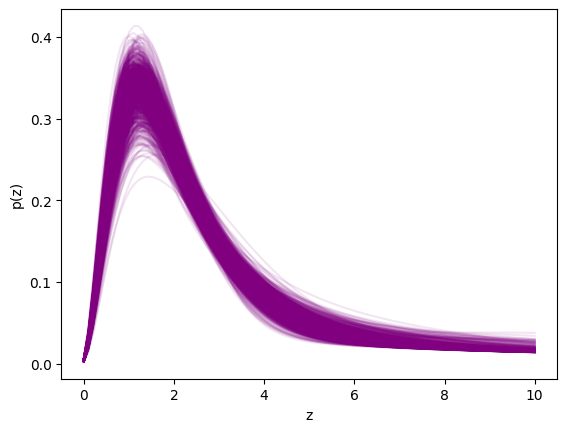

In [9]:
z_grid = np.linspace(0.0, 10.0, 100)
logm_grid = np.linspace(7, 13, 10)
init_sample=100000
nsamples = 1000
sampled_curves = pr.draw_allowed_parameter_curves(z_grid, init_sample, nsamples)
nzs = pr.draw_nz_prior(z_grid, logm_grid, sampled_curves)
pr.plot_nz_prior_draws(z_grid, nzs, nsamples)
plt.ylabel('p(z)')
plt.xlabel('z')

Text(0.5, 0, 'log(m)')

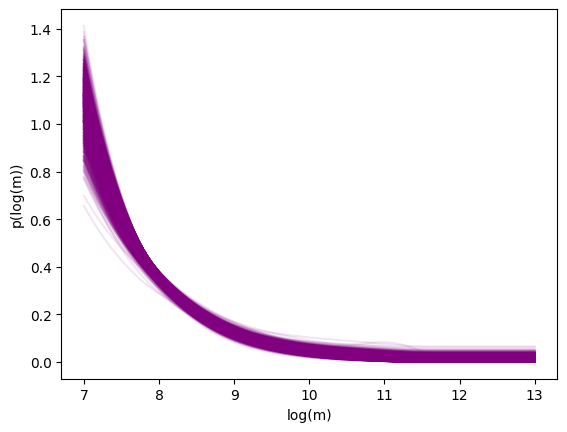

In [10]:
z_grid = np.linspace(0.0, 10.0, 5)
logm_grid = np.linspace(7, 13, 100)
init_sample = 100000
nsamples = 1000
sampled_curves = pr.draw_allowed_parameter_curves(z_grid, init_sample, nsamples)
mass_priors = pr.draw_mass_prior(z_grid, logm_grid, sampled_curves)
pr.plot_mass_prior_draws(logm_grid, mass_priors, nsamples)
plt.ylabel('p(log(m))')
plt.xlabel('log(m)')

In [11]:
dz, dlogm = 0.1, 0.05
z_min, z_max = 0.0, 10.0
logm_min, logm_max = 7.0, 13.0
grid_params = np.array([dz, dlogm, z_min, z_max, logm_min, logm_max])

z_grid, logm_grid = pr.setup_grids(grid_params)

priors = pr.load_priors(z_grid, logm_grid, 100, init_sample=10000)


Text(0.5, 0, 'log(m)')

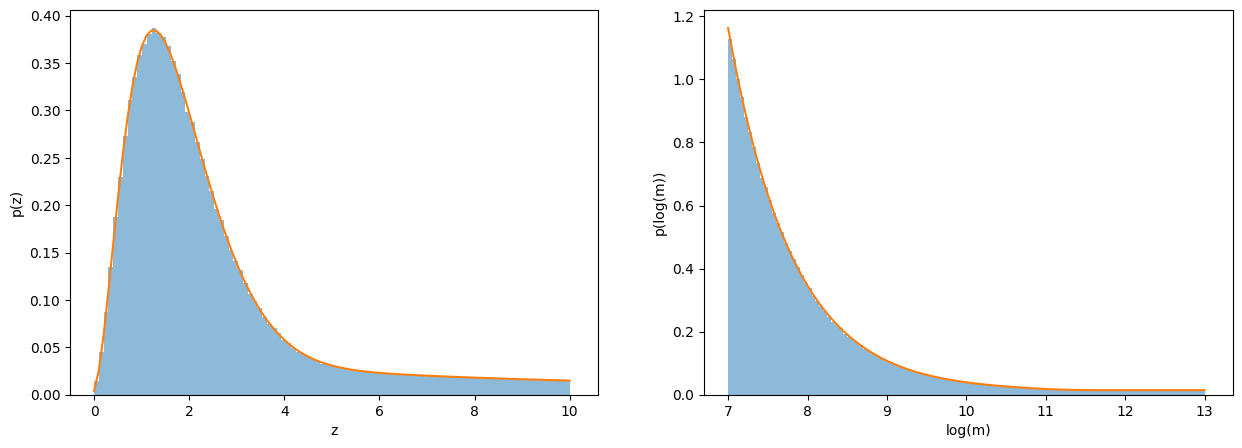

In [12]:
z_samples, m_samples, p_z, p_m = pr.sample_priors(z_grid, logm_grid, priors, grid_params, 1000000, plotting=True)
z_bins, m_bins = pr.setup_bins(grid_params)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].hist(z_samples, density=True, alpha=0.5, bins = z_bins)
axes[0].plot(z_grid, p_z)
axes[0].set_ylabel('p(z)')
axes[0].set_xlabel('z')

axes[1].hist(m_samples, density=True, alpha=0.5, bins = m_bins)
axes[1].plot(logm_grid, p_m)
axes[1].set_ylabel('p(log(m))')
axes[1].set_xlabel('log(m)')
